# Fine-tuning ResNet18 for Cyanobacteria Toxicity Classification

**Objective:** Fine-tune a pretrained ResNet18 model to classify *Microcoleus anatoxicus* cyanobacteria from image data, including training, evaluation, calibration, and interpretability analyses.

## 1. Imports & Utilities

In [7]:
import copy
import math
import os
import subprocess
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import yaml
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve
)
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import models, datasets
from torchvision.models import ResNet18_Weights
from tqdm import tqdm

from src.config_utils import load_config

config = load_config(path='../configs/config_finetune_resnet18.yaml')

FIG_OUT  = os.path.join('..','outputs','figures', 'Switzerland', 'finetune_resnet18')

# Generate Run ID: date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)

Run ID : 2025-07-27_3319866


In [8]:
# Device utility
def get_best_device():
    """Get the best available device with fallback."""
    if torch.backends.mps.is_available():
        try:
            test_tensor = torch.randn(10, 10, device='mps')
            _ = test_tensor @ test_tensor
            print("MPS is available and working")
            return torch.device('mps')
        except Exception as e:
            print(f"MPS failed test: {e}. Falling back to CPU")
            return torch.device('cpu')
    elif torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_best_device()
config['training']['device'] = device

MPS is available and working


## 2. Data Preparation

In [9]:
# Define transforms based on config
data_cfg = config['augmentation']
train_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.RandomHorizontalFlip() if data_cfg['horizontal_flip'] else transforms.Lambda(lambda x: x),
    transforms.RandomRotation(data_cfg['rotation']),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'], std=data_cfg['normalization']['std'])
])

# Create dataset
dataset = datasets.ImageFolder(root=os.path.join( '../', config['data']['path']), transform=train_transform)

# Split into train/val
total = len(dataset)
train_size = int(config['data']['train_split'] * total)
val_size = total - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_set, batch_size=config['data']['batch_size'], shuffle=True, num_workers=config['data']['num_workers'])
val_loader   = DataLoader(val_set,   batch_size=config['data']['batch_size'], shuffle=False, num_workers=config['data']['num_workers'])

## 3. Model Definition

In [10]:
model_cfg = config['model']
model = getattr(models, model_cfg['name'])(weights=ResNet18_Weights.DEFAULT)
if hasattr(model, 'fc'):
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, model_cfg['num_classes'])
elif hasattr(model, 'classifier'):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, model_cfg['num_classes'])
model = model.to(config['training']['device'])

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=float(config['training']['learning_rate']), weight_decay=float(config['training']['weight_decay']))

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(loader, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc   = correct.float()  / total
    return epoch_loss, epoch_acc.item()


def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds  = []
    all_probs  = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Val'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            probs  = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc  = correct.float() / total
    return (
        epoch_loss,
        epoch_acc.item(),
        np.array(all_labels),
        np.array(all_preds),
        np.array(all_probs)
    )

try:
    summary(model, input_size=(3, 64, 64), device=str(config['training']['device']))
except Exception as e:
    print(f"Model summary not supported on {config['training']['device']}: {e}. Showing summary on CPU instead.")
    cpu_model = model.to('cpu')
    summary(cpu_model, input_size=(3, 64, 64), device='cpu')
    model.to(config['training']['device'])

Model summary not supported on mps: Input device is not valid, please specify 'cuda' or 'cpu'. Showing summary on CPU instead.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 

## 4. Training Loop

In [12]:
# Training and validation
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_roc_auc': [],  'val_avg_prec': []
}
for epoch in range(config['training']['epochs']):
    print(f"Epoch {epoch+1}/{config['training']['epochs']}")
    t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, config['training']['device'])
    v_loss, v_acc, y_true, y_pred, y_prob = eval_model(model, val_loader, criterion, config['training']['device'])
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)
    roc_auc   = roc_auc_score(y_true, y_prob)
    avg_prec  = average_precision_score(y_true, y_prob)
    history['val_roc_auc'].append(roc_auc)
    history['val_avg_prec'].append(avg_prec)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 5
    num_bad_epochs = 0

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        num_bad_epochs = 0
    else:
        num_bad_epochs += 1

    if num_bad_epochs >= patience:
        print(f"No improvement for {patience} epochs. Early stopping.")
        break

    print(f"Train loss: {t_loss:.4f}, acc: {t_acc:.4f} | Val loss: {v_loss:.4f}, acc: {v_acc:.4f} | ROC AUC: {roc_auc:.3f}, AP: {avg_prec:.3f}")

model.load_state_dict(best_model_wts)

Epoch 1/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


Train loss: 0.4001, acc: 0.7991 | Val loss: 0.2480, acc: 0.9115 | ROC AUC: 0.967, AP: 0.979
Epoch 2/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.1981, acc: 0.9129 | Val loss: 0.1644, acc: 0.9381 | ROC AUC: 0.986, AP: 0.990
Epoch 3/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


Train loss: 0.1896, acc: 0.9308 | Val loss: 0.1147, acc: 0.9646 | ROC AUC: 0.996, AP: 0.997
Epoch 4/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.1265, acc: 0.9464 | Val loss: 0.0834, acc: 0.9646 | ROC AUC: 0.998, AP: 0.999
Epoch 5/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0887, acc: 0.9688 | Val loss: 0.0829, acc: 0.9646 | ROC AUC: 0.996, AP: 0.996
Epoch 6/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0617, acc: 0.9821 | Val loss: 0.0629, acc: 0.9823 | ROC AUC: 0.998, AP: 0.999
Epoch 7/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.86s/it]


Train loss: 0.0797, acc: 0.9665 | Val loss: 0.1267, acc: 0.9469 | ROC AUC: 0.994, AP: 0.996
Epoch 8/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.1743, acc: 0.9442 | Val loss: 0.2126, acc: 0.9469 | ROC AUC: 0.975, AP: 0.981
Epoch 9/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.83s/it]


Train loss: 0.1139, acc: 0.9688 | Val loss: 0.1322, acc: 0.9469 | ROC AUC: 0.988, AP: 0.988
Epoch 10/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.1035, acc: 0.9621 | Val loss: 0.1208, acc: 0.9646 | ROC AUC: 0.989, AP: 0.993
Epoch 11/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0828, acc: 0.9643 | Val loss: 0.0777, acc: 0.9823 | ROC AUC: 0.997, AP: 0.998
Epoch 12/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0575, acc: 0.9844 | Val loss: 0.0428, acc: 0.9823 | ROC AUC: 0.999, AP: 0.999
Epoch 13/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0705, acc: 0.9732 | Val loss: 0.1005, acc: 0.9469 | ROC AUC: 0.996, AP: 0.997
Epoch 14/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0935, acc: 0.9732 | Val loss: 0.0771, acc: 0.9646 | ROC AUC: 0.997, AP: 0.998
Epoch 15/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0436, acc: 0.9888 | Val loss: 0.0707, acc: 0.9823 | ROC AUC: 0.997, AP: 0.998
Epoch 16/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.83s/it]


Train loss: 0.0441, acc: 0.9821 | Val loss: 0.0958, acc: 0.9735 | ROC AUC: 0.995, AP: 0.996
Epoch 17/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Train loss: 0.0297, acc: 0.9933 | Val loss: 0.0404, acc: 0.9823 | ROC AUC: 1.000, AP: 1.000
Epoch 18/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


Train loss: 0.0175, acc: 0.9955 | Val loss: 0.0260, acc: 1.0000 | ROC AUC: 1.000, AP: 1.000
Epoch 19/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.86s/it]


Train loss: 0.0232, acc: 0.9955 | Val loss: 0.0408, acc: 0.9823 | ROC AUC: 0.999, AP: 1.000
Epoch 20/20


Val: 100%|██████████| 8/8 [00:22<00:00,  2.86s/it]

Train loss: 0.0115, acc: 0.9955 | Val loss: 0.0332, acc: 1.0000 | ROC AUC: 1.000, AP: 1.000


<All keys matched successfully>

In [13]:
os.makedirs('../outputs/logs/Switzerland/finetune_resnet18', exist_ok=True)
hist_path = f"../outputs/logs/Switzerland/finetune_resnet18/history_finetune_resnet18_{run_id}.pkl"
pd.to_pickle(history, hist_path)

os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
hist_path = f"../outputs/checkpoints/Switzerland/finetune_resnet18/history_finetune_resnet18_{run_id}.pkl"
pd.to_pickle(history, hist_path)

## 5. Results Visualization

Accuracy curves saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_accuracy_curves.png


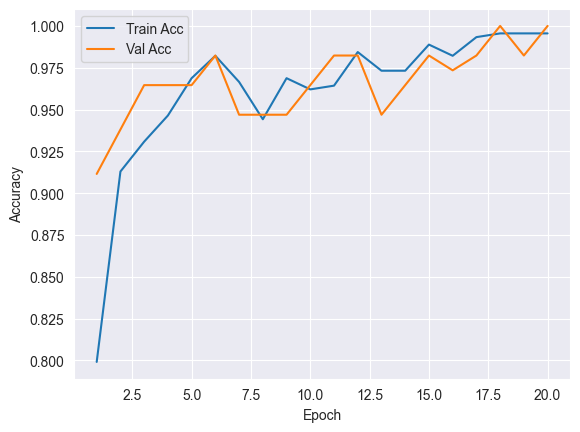

In [14]:
# Plot loss and accuracy curves
epochs = range(1, config['training']['epochs']+1)

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save accuracy curves figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_accuracy_curves.png")
plt.savefig(fig_path, dpi=300)
print("Accuracy curves saved in:", fig_path)

plt.show()

Loss curves saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_loss_curves.png


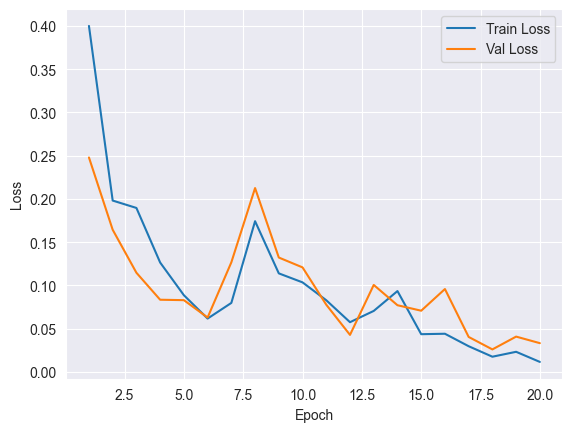

In [15]:
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save loss curves figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_loss_curves.png")
plt.savefig(fig_path, dpi=300)
print("Loss curves saved in:", fig_path)

plt.show()

ROC saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_roc_curve.png


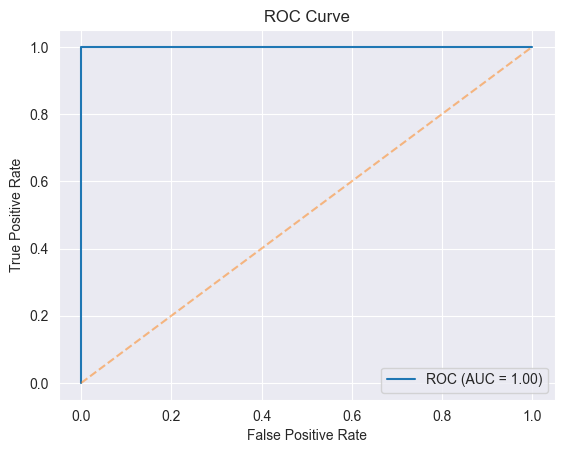

In [16]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
roc_auc_val = roc_auc_score(y_true, y_prob)
ap_val = average_precision_score(y_true, y_prob)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Save ROC figure
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"), dpi=300)
print("ROC saved in:", os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"))
plt.show()

PR curve saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_pr_curve.png


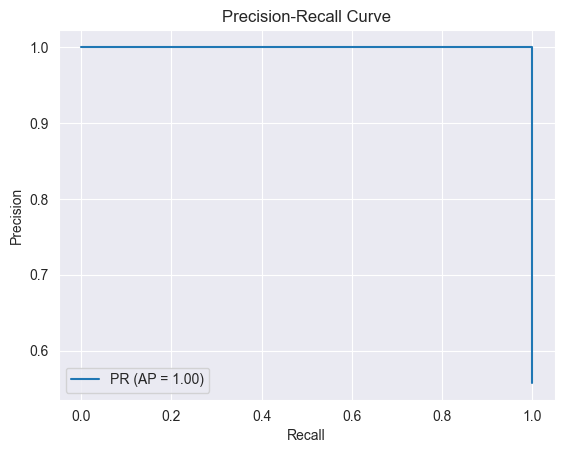

In [17]:
# Plot PR
plt.figure()
plt.plot(recall, precision, label=f'PR (AP = {ap_val:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.savefig(os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"), dpi=300)
print("PR curve saved in:", os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"))

plt.show()

Confusion matrix saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_confusion_matrix.png


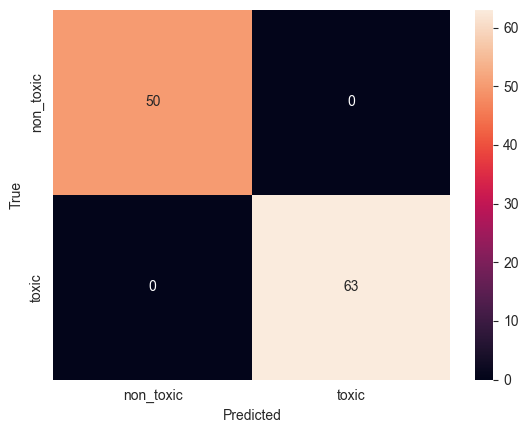

In [18]:
# Confusion matrix
target_names = dataset.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True')
plt.xlabel('Predicted')

# Save confusion matrix figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300)
print("Confusion matrix saved in:", fig_path)

plt.show()

Report CSV saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_classification_report.csv
Report image saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_classification_report.png


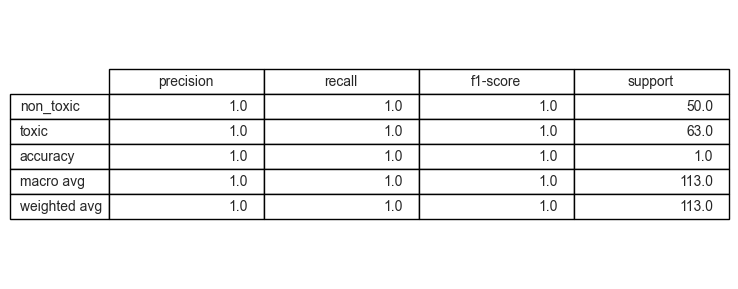

In [19]:
# Classification report
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names, output_dict=True)).T

csv_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.csv")
report_df.to_csv(csv_path, index=True)
print("Report CSV saved in:", csv_path)

fig, ax = plt.subplots(figsize=(8, len(report_df) * 0.5 + 1))
ax.axis('off')

table = ax.table(
    cellText=report_df.round(2).values,
    rowLabels=report_df.index,
    colLabels=report_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

img_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.png")
fig.savefig(img_path, dpi=300, bbox_inches='tight')
print("Report image saved in:", img_path)

## 8. Calibration (Platt Method)

Val: 100%|██████████| 8/8 [00:22<00:00,  2.87s/it]

Brier score (calibrated) : 0.0265


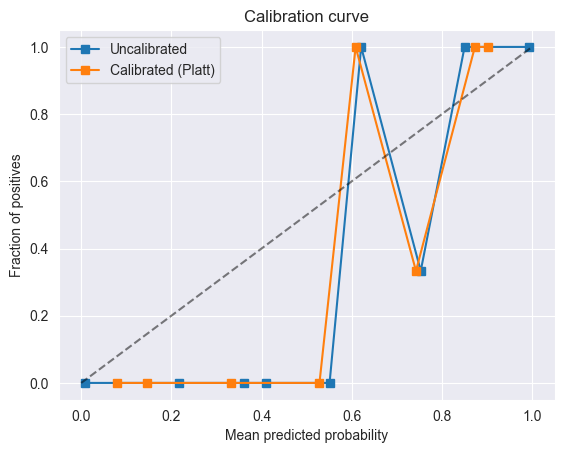

In [20]:
v_loss, v_acc, y_true_val, y_pred_val, y_prob_val = eval_model(
    model, val_loader, criterion, config['training']['device']
)

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            inputs = torch.stack([transforms.ToTensor()(img) for img in X]).to(config['training']['device'])
            outputs = self.model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
        return probs

wrapper = ModelWrapper(model)
calibrator = CalibratedClassifierCV(wrapper, cv='prefit', method='sigmoid')

lr_cal = LogisticRegression().fit(
    y_prob_val.reshape(-1,1),
    y_true_val
)

y_prob_cal = lr_cal.predict_proba(y_prob_val.reshape(-1,1))[:,1]

brier = brier_score_loss(y_true_val, y_prob_cal)
print(f"Brier score (calibrated) : {brier:.4f}")

frac_pos, mean_pred = calibration_curve(y_true_val, y_prob_val, n_bins=10)
frac_pos_cal, mean_pred_cal = calibration_curve(y_true_val, y_prob_cal, n_bins=10)

plt.figure()
plt.plot(mean_pred,   frac_pos,   's-', label='Uncalibrated')
plt.plot(mean_pred_cal, frac_pos_cal, 's-', label='Calibrated (Platt)')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_calibration_curve.png"), dpi=300)
plt.show()


## 7. Grad-CAM Interpretability

Image saved in: ../outputs/figures/Switzerland/finetune_resnet18/2025-07-27_3319866_grad-cam.png


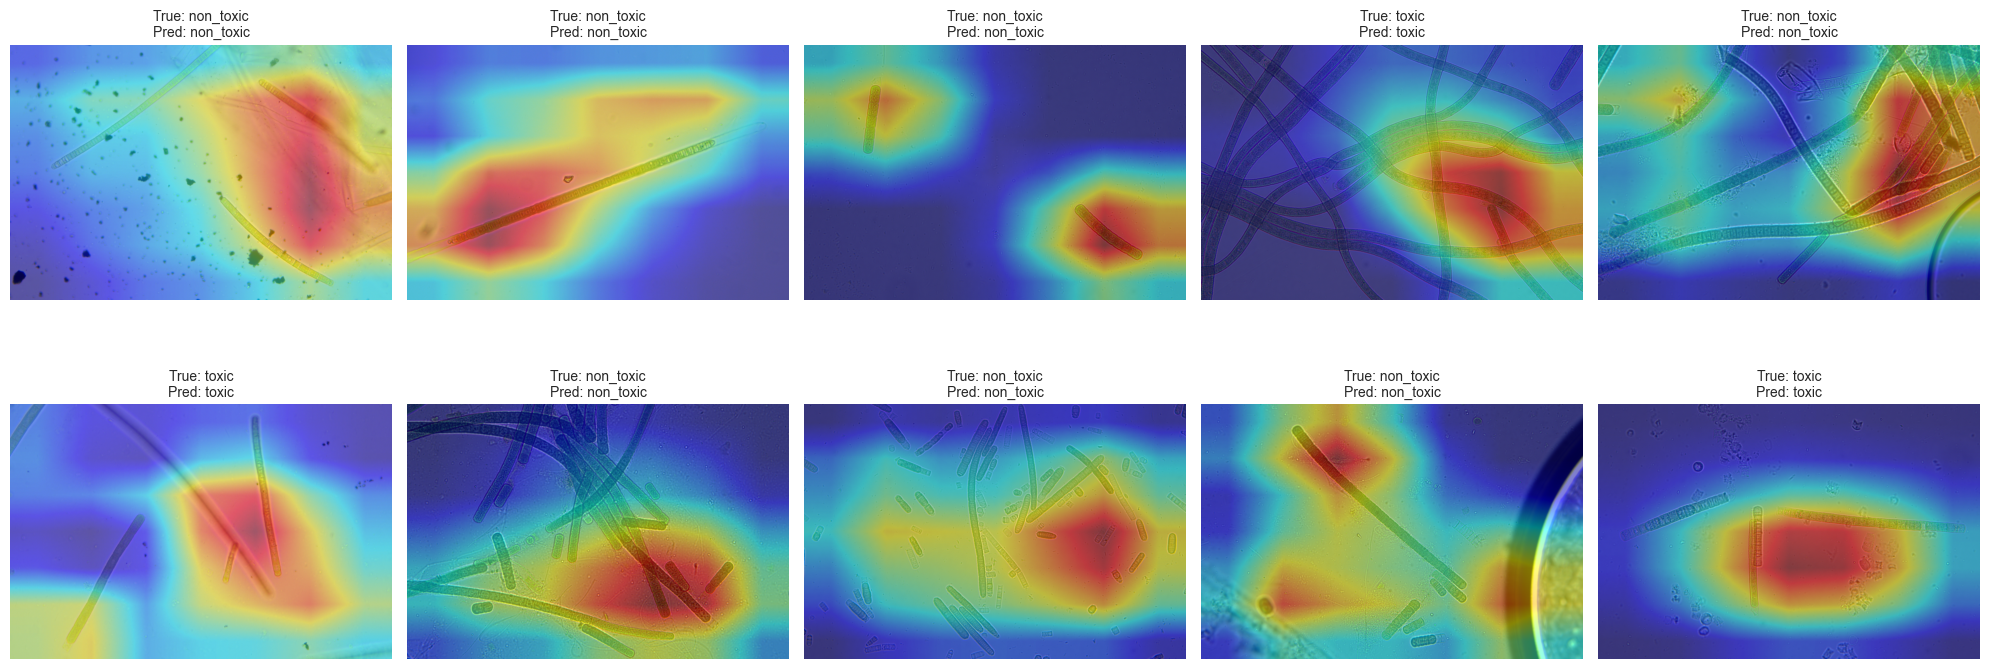

In [24]:
vis_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'], std=data_cfg['normalization']['std'])
])

target_layer = model.layer4[-1].conv2
cam_extractor = GradCAM(model=model, target_layers=[target_layer])

n_display = 10

n_cols = 5
n_rows = math.ceil(n_display / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 4, n_rows * 4),
                         dpi=100)
axes = axes.flatten()

for idx in range(n_display):
    ax = axes[idx]

    tensor_aug, true_label = val_set[idx]
    orig_path, _ = val_set.dataset.samples[val_set.indices[idx]]
    orig_img: Image.Image = Image.open(orig_path).convert('RGB')
    W, H = orig_img.size

    orig_resized = transforms.Resize(tuple(data_cfg['resize']))(orig_img)
    input_tensor = vis_transform(orig_resized).unsqueeze(0)
    input_tensor = input_tensor.to(config['training']['device'])

    outputs = model(input_tensor)
    pred_label = outputs.argmax(dim=1).item()

    grayscale_cam = cam_extractor(input_tensor=input_tensor)[0]

    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((W, H), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img, dtype=np.float32) / 255.0

    rgb_orig = np.array(orig_img, dtype=np.float32) / 255.0
    cam_on_orig = show_cam_on_image(rgb_orig, cam_resized, use_rgb=True)

    ax.imshow(cam_on_orig)
    ax.set_title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}",
                 fontsize=10)
    ax.axis('off')

for ax in axes[n_display:]:
    ax.axis('off')

plt.tight_layout()

fig_path = os.path.join(FIG_OUT, f"{run_id}_grad-cam.png")
plt.savefig(fig_path, dpi=300)
print("Image saved in:", fig_path)

plt.show()

## 6. Save Model & Config

In [25]:
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
# Save model on CPU for compatibility, then move back
torch.save(model.to('cpu').state_dict(), f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')
model.to(config['training']['device'])

with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Training complete. Model and config saved in outputs')

Training complete. Model and config saved in outputs
